# MSIN0097 Individual Corsework

https://github.com/ToshaQE/Predictive-Individual

Word Count : 1968

### Installing Libraries and Dependencies

In [162]:
# To display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."
%autosave 60

import pandas as pd
import numpy as np
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.dummy import DummyClassifier
import joblib
import pickle
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Autosaving every 60 seconds


Stock price prediction has for a long time been a subject of many debates and exhaustive research. One concept which emerged from the literature, and which has largely dominated the debate ever since is the Efficient Market Hypothesis (EMH). EMH in its strong form states that at any point in time all information regarding a particular stock is incorporated in its current price, and it is equally likely that the price will go up or down in the immediate future, making any educated attempts at its prediction obsolete. However, empirical data shows that the strong form of EMH does not hold, and in reality, it is possible to make use of openly available fundamental and technical stock indicators to predict the likely direction of its price. This is exactly what this paper will attempt to do.

In particular, we will examine a number of machine learning algorithms to determine whether a hypothetical investor should hold, sell or buy a stock given a set of indicators available to him today. The outcome variable is determined using the following logic – if the stock’s price decreases by 1%  N days in the future, the investor should sell the stock today; if price goes up by 1%, the investor should buy more stock; if stock’s value remains somewhere in between, the investor should hold. The algorithms examined hence will attempt to solve a 3-class classification task.

Importantly, the structure and the analysis of this paper is insipid by the work of Matloob and Khushi (2021) (https://doi.org/10.3390/asi4010017). However, we significantly extend their analysis by deriving the labels 5 days further into the future, adding new models, fine-tuning them and deriving a voting classifier.

Business applications of instruments predicting stock price direction varies drastically. It can be applied by an asset fund trying to generate additional returns on its clients’ holdings or by a central banker analysing stock market’s behaviour in the immediate future to understand potential policy context. In short, any business or an institution that is involved in stock market trade might wish to employ an algorithm developed and analysed in this paper.

## Loading in and formatting the data

### Loading in the data

In [2]:
data = pd.read_csv("55_Firms_2.csv")
data.head(5)

,Date,AAPL Close,AAPL Adj. Close,AAPL P/E (LTM),AAPL EPS - Est High (NTM),AAPL EPS - Est Low (NTM),AAPL Volume,AAPL SI (%),AAPL Vol,AAPL # Buys,...,AMGN EPS - Est Low (NTM),AMGN Volume,AMGN SI (%),AMGN Vol,AMGN # Buys,AMGN # Sell,AMGN # Hold,AMGN Rating,AMGN Mkt Cap,AMGN EPS - Est Avg (NTM)
0,1/2/2003,0.264285,0.226300,82.589062,0.00714,0.00232,182317016,NaN,0.051974,1,...,1.55,14254890,NaN,0.363758,NaN,NaN,NaN,NaN,63478.08136,1.6187
1,1/3/2003,0.266071,0.227830,83.147187,0.00714,0.00232,147975184,NaN,0.052158,1,...,1.55,8311770,NaN,0.346956,NaN,NaN,NaN,NaN,63310.76282,1.6187
2,1/6/2003,0.266071,0.227830,83.147187,0.00714,0.00214,391594000,NaN,0.051699,1,...,1.55,14671690,NaN,0.352543,NaN,NaN,NaN,NaN,64700.79379,1.6187
3,1/7/2003,0.265178,0.227065,82.868125,0.00714,0.00214,346265920,NaN,0.050062,1,...,1.55,15768390,NaN,0.345180,NaN,NaN,NaN,NaN,64662.18182,1.6191
4,1/8/2003,0.259821,0.222478,81.194062,0.00714,0.00214,230100640,NaN,0.049807,1,...,1.55,12139460,NaN,0.346149,NaN,NaN,NaN,NaN,62911.77244,1.6191


We used Koyfin platform (https://koyfin.com) to download the data. The data contains stocks closing and adjusted prices, four fundamental and technical indicators, as well as analyst recommendations for 55 firms listed on top of the S&P 500 index (as of 01/03/2022) for the period from 02 Jan 2003 to 02 Dec 2019 and contains 4260 rows. 
Tickers for the first ten companies can be seen below:

In [3]:
#Making a list of unique companies
all_collumns = list(data.columns)
all_tickers = []
counter = 15

for i in all_collumns[1:]:
    if counter%14 == True:
        all_tickers.append(i.split(" ", 1)[0])
    counter += 1

len(all_tickers)
all_tickers[0:10]

55

['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'FB', 'JPM', 'UNH', 'JNJ', 'PG', 'V']

The 14 original features are below:

In [4]:
all_collumns = list(data.columns)
features = []
counter = 14

for i in all_collumns[0:15]:
    features.append(i.split(" ", 1)[1])

features[1:]

['Close',
 'Adj. Close',
 'P/E (LTM)',
 'EPS - Est High (NTM)',
 'EPS - Est Low (NTM)',
 'Volume',
 'SI (%)',
 'Vol',
 '# Buys',
 '# Sell',
 '# Hold',
 'Rating',
 'Mkt Cap',
 'EPS - Est Avg (NTM)']

The initial format of our data, however, is not well-suited for machine learning analysis as it lists companies’ data in a horizontal fashion. Hence, we create 55 separate data frames, each containing data for an individual company. Furthermore, we create some additional features such as stock price standard deviation over 5, 10 and 15 days and percentage of each recommendation type out of total number of recommendations (see below for full feature list). Finally, we create sell, hold and buy labels for 15 days in the future.

First 5 rows of an individual dataframe for Apple can be seen below:

In [5]:
#Separating the data into dataframes for each company, dealing with N/A's and creating new features;
#Having perfomred the above manipulations, we merge data into one DataFrame

dfs = []
indices = indices = list(range(0,784,14))
counter = 1

for i in indices[0:-1]:
    df = pd.DataFrame(np.nan, np.arange(4259), columns=features)
    #Setting the first column equal to date
    df.iloc[:,0]=data.iloc[:,0]

    if i != 756:
        start = i+1
        stop = indices[counter]+1
        df.iloc[:,1:15] = data.iloc[:,start:stop]
    
    else:
        start = i
        stop = 756 + 15
        df.iloc[:,1:15] = data.iloc[:,start:stop]


    # df['Total Rec'] = df['# Buys'] + df['# Sell'] + df['# Hold']

    #Total number of reccomentaions and % of each recommnedtion type (buy, sell, hold)
    df.insert(12,'Total Rec', 0)
    df.iloc[:,12] = df['# Buys'] + df['# Sell'] + df['# Hold']
    df.insert(13,'% Buy', 0)
    df.insert(14,'% Sell', 0)
    df.insert(15,'% Hold', 0)

    pc_change = 0.01

    for n in range(0,len(df.index)-15):

        total_recs = df.iloc[n]['Total Rec']

        if (total_recs != 0):
            df.at[n, '% Buy'] = df.iloc[n]['# Buys']/total_recs

            df.at[n, '% Sell'] = df.iloc[n]['# Sell']/total_recs

            df.at[n, '% Hold'] = df.iloc[n]['# Hold']/total_recs
        
        else:
            df.at[n, '% Buy'] = 0

            df.at[n, '% Sell'] = 0

            df.at[n, '% Hold'] = 0
    
       
        price_0 = df.iloc[n]['Close']      
        price_1 = df.iloc[n+1]['Close'] 
        price_2 = df.iloc[n+2]['Close'] 
        price_3 = df.iloc[n+3]['Close']
        price_4 = df.iloc[n+4]['Close'] 
        price_5 = df.iloc[n+5]['Close']
        price_6 = df.iloc[n+6]['Close'] 
        price_7 = df.iloc[n+7]['Close']
        price_8 = df.iloc[n+8]['Close'] 
        price_9 = df.iloc[n+9]['Close']
        price_10 = df.iloc[n+10]['Close']
        price_11 = df.iloc[n+11]['Close']
        price_12 = df.iloc[n+12]['Close']
        price_13 = df.iloc[n+13]['Close']
        price_14 = df.iloc[n+14]['Close']
        price_15 = df.iloc[n+15]['Close']

        price_days = [price_0, price_1, price_2, price_3, price_4, price_5, price_6, price_7, price_8,
        price_9, price_10, price_11, price_12, price_13, price_14, price_15]

        df.at[n+5,'std_5days'] = np.std(price_days[0:5], ddof=1) 
        df.at[n+5,'std_10days'] = np.std(price_days[0:10], ddof=1)
        df.at[n+15,'std_15days'] = np.std(price_days[0:15], ddof=1) 


        df.at[n+5, '% change_5d'] = (price_4-price_0)/price_0
        df.at[n+10, '% change_5d'] = (price_9-price_0)/price_0
        df.at[n+15, '% change_5d'] = (price_14-price_0)/price_0


        for j in range(0, 16):

            if j==0:
                continue

            else:
                # buy=2 sell=0 hold=1
                if((price_days[j]-price_0) >= pc_change * price_0):
                    df.at[n,'day_' + str(j)] = 2

                elif((price_days[j]-price_0) <= -(pc_change * price_0)):
                    df.at[n,'day_' + str(j)] = 0

                else:
                    df.at[n,'day_' + str(j)] = 1

    # Dealing with N/A's
    #Truncating the data for younger companies with N/A's only at the start of the 2000's  
    df.iloc[:,1:] = df.iloc[:,1:].astype(float).interpolate()
    df.dropna(thresh=35, inplace=True)
    df.fillna(method='bfill', inplace=True)
    df.reset_index(drop=True, inplace=True)



    # df.dropna(subset=['Close'], inplace=True)

    dfs.append(df)
    counter += 1


dfs[1].head(5)

,Date,Close,Adj. Close,P/E (LTM),EPS - Est High (NTM),EPS - Est Low (NTM),Volume,SI (%),Vol,# Buys,...,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15
0,1/9/2003,27.905,17.580627,35.994469,1.08,0.900,62048642.0,0.953692,0.307837,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1/10/2003,27.960,17.615278,36.065413,1.08,0.900,67985474.0,0.953692,0.306803,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/13/2003,28.195,17.763332,36.368538,1.08,0.900,61040600.0,0.953692,0.305531,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/14/2003,28.485,17.946037,36.742607,1.08,0.915,54441838.0,0.953692,0.304476,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/15/2003,28.135,17.725531,36.291144,1.08,0.915,59999384.0,0.953692,0.284455,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#All features + labels
all_collumns = list(dfs[1].columns)
all_collumns

['Date',
 'Close',
 'Adj. Close',
 'P/E (LTM)',
 'EPS - Est High (NTM)',
 'EPS - Est Low (NTM)',
 'Volume',
 'SI (%)',
 'Vol',
 '# Buys',
 '# Sell',
 '# Hold',
 'Total Rec',
 '% Buy',
 '% Sell',
 '% Hold',
 'Rating',
 'Mkt Cap',
 'EPS - Est Avg (NTM)',
 'std_5days',
 'std_10days',
 'std_15days',
 '% change_5d',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'day_7',
 'day_8',
 'day_9',
 'day_10',
 'day_11',
 'day_12',
 'day_13',
 'day_14',
 'day_15']

Our resulting features are as follows:

| Dataframe Column     	| Indicator                                         	|
|----------------------	|---------------------------------------------------	|
| Close                	| Closing Price                                     	|
| Adj. Close           	| Adjusted Closing Price                            	|
| P/E (LTM)            	| PE Ratio (Last 12 Months)                         	|
| EPS - Est High (NTM) 	| EPS Consensus High (Next 12 Months)               	|
| EPS - Est Low (NTM)  	| EPS Consensus Low (Next 12 Months)                	|
| EPS - Est Avg(NTM)   	| EPS Consensus Average (Next 12 Months)            	|
| SI (%)               	| Short Interest                                    	|
| Vol                  	| Volatility Over 1 Month                           	|
| Volume               	| Volume Traded                                     	|
| # Buys               	| Number of Buy Recommendations                     	|
| # Sell               	| Number of Sell Recommendations                    	|
| # Hold               	| Number of Hold Recommendations                    	|
| Total Rec            	| Total Number of Recommendations                   	|
| % Buys               	| % of Buy Recommendations out of Total Rec         	|
| % Sell               	| % of Sell Recommendations out of Total Rec        	|
| % Hold               	| % of Hold Recommendations out of Total Rec        	|
| Rating               	| Analyst Rating                                    	|
| Mkt Cap              	| Market Capitalization                             	|
| std_5days            	| Standart Deviation in Price over the Last 5 Days  	|
| std_10days           	| Standart Deviation in Price over the Last 10 Days 	|
| std_15days           	| Standart Deviation in Price over the Last 15 Days 	|
| % change_5d          	| % Change in Price over the Last 15 Days           	|

The resulting labels are as follows:

| Dataframe Column 	| Label                                                                                                                        	|
|------------------	|------------------------------------------------------------------------------------------------------------------------------	|
| day_n            	| What is investor's optimal strategy if he intends to collect his returns n days in the future: Sell (0), Hold (1), or Buy (2) 	|

We then merge all dataframes to form a new long dataframe, which is much more well-suited for machine learning analysis, with total of 151,424 rows.

It is important to note that we are well aware of all caveats associated with working with time-series data, and that we do not run any root tests nor apply any related transformations for a simple reason: we are interested in the predictive capability of our features irrespective of the time (as per Matloob and Khushi (2021)). 


In [7]:
data_long = pd.concat(dfs)

To ensure that the models do not pick up on any long-term trends while training we shuffle the data (and reset the index).

In [8]:
df_new = data_long.sample(frac=1).reset_index(drop=True)

## Data analysis and Visualisations


First, we would like to see whether an investors strategy (and the position he favors today) might change depending on the time horizon at the end of which he expects to collect his returns.  To do this we plot what would his strategy be if he knew the future price one day at a time over 15 days in the future.

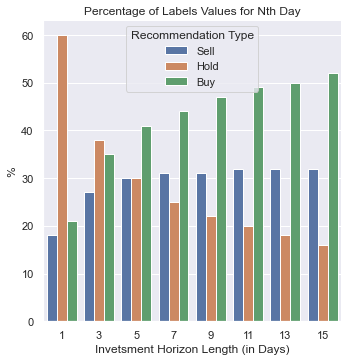

In [129]:
df = df_new

#Separating df into features and labels  
features = df.iloc[:,1:23]
labels = df.iloc[:,23:]

vis1_col = ['#Sell','#Hold', '#Buy']
days = list(labels.columns)

vis1 = pd.DataFrame(index=days, columns = vis1_col)

for i in days:
    vis1.loc[i, '#Sell'] = (df.loc[:,i] == 0).sum()
    vis1.loc[i, '#Hold'] = (df.loc[:,i] == 1).sum()
    vis1.loc[i, '#Buy'] = (df.loc[:,i] == 2).sum()
    vis1['#Total'] = vis1['#Sell'] + vis1['#Hold'] + vis1['#Buy']
    # vis1.loc[:,'#Total'] = vis1.loc[:,'#Sell'] + vis1.loc[:,'#Hold'] + vis1.loc[:, '#Buy']
    vis1.loc[:, '% Sell'] = (vis1.loc[:, '#Sell']/vis1.loc[:,'#Total'])*100
    vis1.loc[:, '% Hold'] = (vis1.loc[:, '#Hold']/vis1.loc[:,'#Total'])*100
    vis1.loc[:, '% Buy'] = (vis1.loc[:, '#Buy']/vis1.loc[:,'#Total'])*100

vis1.insert(0,'Day_n', list(range(1,16)))
vis1.reset_index(drop=True, inplace=True)
    
vis1 = vis1.astype(float).round()
vis11 = vis1.iloc[:, 5:]
vis11.rename(columns={'% Sell':'Sell','% Hold':'Hold', '% Buy':'Buy'},
inplace=True)
vis11.insert(0,'Day_n', list(range(1,16)))
vis11 = vis11.iloc[::2,:]
#vis11
vis11 = pd.melt(vis11, id_vars="Day_n", var_name="Recommendation Type", value_name="%")
# vis11
sns.set_theme()

vis1_sns = sns.factorplot(data=vis11, x='Day_n', y='%', 
hue='Recommendation Type', kind='bar', legend=False)

vis1_sns.set(xlabel='Invetsment Horizon Length (in Days)', ylabel='%')
plt.legend(loc='upper center', title='Recommendation Type')

vis1_sns.set(title='Percentage of Labels Values for Nth Day')
plt.show();
#vis11

It appears that his strategy would change drastically depending on the time horizon – at the start of the horizon there is a 60% chance that his preferred strategy would be to hold a stock, and only around 20% that he should sell or buy it. Looking at the stock’s price on the 15th day, however, today he would prefer to buy more with a 52% chance, sell with a 32% chance and hold with a 16% chance. We hence, should expect our models to give different prediction given the day label.

One might argue that this finding suggest that we might have to rebalance our classes. We counter this critique by providing two arguments. First, we intend to use F1 Weighted as the scoring techniques, which accounts for possible problems associated with imbalanced classes. Second, we do not wish to lose valuable information which potentially lies in the imbalanced classes. This is particularly important given the smooth pattern of the graph above, which suggests that this imbalance is not random. Furthermore, our test data will have the same distribution as above, meaning that it should not be a problem within the context of this paper. Lastly, we account for this potential issue in the fine-tuning section of the paper by passing a hyper-parameter into the grid search that gives classes weights proportionate to their frequency.   

Now we turn our attention to a diffrenet visualisation.

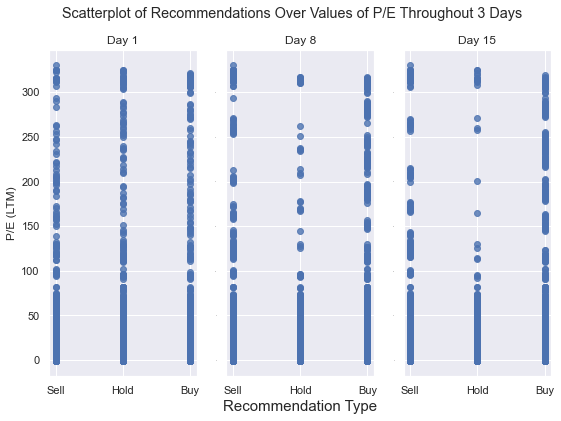

In [124]:
df = df_new
d = {'Position_Type':['Sell', 'Hold', 'Buy']}
vis2 = pd.DataFrame(d)

plt.figure(figsize=(9, 6))
plt.suptitle('Scatterplot of Recommendations Over Values of P/E Throughout 3 Days')

plt.subplot(1,3,1)
sns.regplot(data=df,  x="day_1", y="P/E (LTM)", fit_reg=False)
plt.xticks(np.arange(0, 3, 1), labels=['Sell', 'Hold', 'Buy'])
plt.xlabel('')
plt.title('Day 1')

plt.subplot(1,3,2)
sns.regplot(data=df,  x="day_8", y="P/E (LTM)", fit_reg=False)
plt.xticks(np.arange(0, 3, 1), labels=['Sell', 'Hold', 'Buy'])
plt.yticks(fontsize=0)
plt.xlabel('Recommendation Type', fontsize=15)
plt.ylabel("", fontsize=18)
plt.title('Day 8')



plt.subplot(1,3,3)
sns.regplot(data=df,  x="day_15", y="P/E (LTM)", fit_reg=False)
plt.xticks(np.arange(0, 3, 1), labels=['Sell', 'Hold', 'Buy'])
plt.yticks(fontsize=0)
plt.xlabel('', fontsize=18)
plt.ylabel("", fontsize=18)
plt.title('Day 15')


plt.show();

This scatterplot demonstrates that the importance of a stock's P/E ratio for determinging the optimal strategy today seems to vary depending on the strategy horizon. For instance, if an inverstor seeks to collect the returns tomorrow, value of P/E ratio might not be a very useful indicator to decide what he should do today. However, as strategy horizon increases, 'Hold' strategy becomes less and less likely for stocks with P/E ratio over 100. Furthermore, the distribution of each strategy type becomes more and more 'clustered' around certain values of P/E with time.

This finding supports the hypothesis that value of fundamental indicators and length of the strategy horizon are crucial for determining the optimal invetsment strategy. Furthermore, it suggests that clustering machine learning techniques might be useful for the aims of this paper.

### Decomposition...?

Although our feature set does not have a particularly high number of dimensions, it still might be useful to run some decomposition techniques and visualise the resulting components in order to check for potentially imporant for analysis patterns and/or clusters. Hence we apply Principal Component Analysis (PCA) and T-Distributed Stochastic Neighbour Embedding (TSNE).
(We only use 2 components, as 95% of variance is explained by the first component alone)

Explained variation per principal component: [0.95640878 0.04358917]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.000s...
[t-SNE] Computed neighbors for 10001 samples in 2.584s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 47787.159491
[t-SNE] KL dive

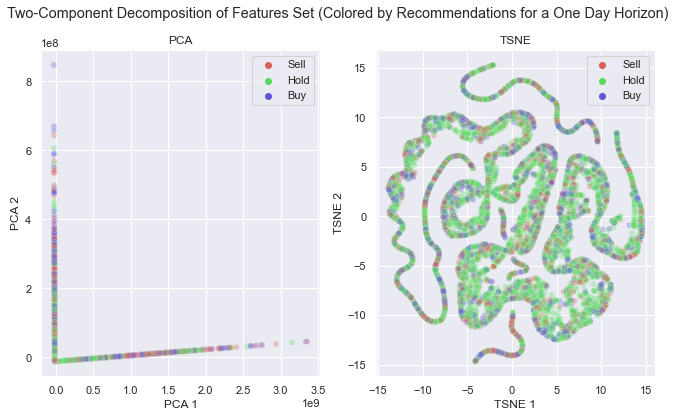

In [139]:
#PCA DF
df = df_new
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.iloc[:,1:23].values)
df['PCA 1'] = pca_result[:,0]
df['PCA 2'] = pca_result[:,1] 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

sns.set_style('darkgrid')
plt.figure(figsize=(11,6))
plt.suptitle('Two-Component Decomposition of Features Set (Colored by Recommendations for a One Day Horizon)')

#PCA vis
plt.subplot(1,2,1)
vis_8 = sns.scatterplot(
    x="PCA 1", y="PCA 2",
    hue="day_1",
    palette=sns.color_palette("hls", 3),
    data=df,
    legend="full",
    alpha=0.3
)

handles, labels  =  vis_8.get_legend_handles_labels()
vis_8.legend(handles, ['Sell', 'Hold', 'Buy'], loc='upper right')
plt.title('PCA')

#TSNE DF (Creating a smaller subset for computational purposes)
df = df_new
N = 10000
df_subset = df.loc[:N,:].copy()
data_subset = df_subset.iloc[:,1:23].values
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
df_subset['TSNE 1'] = tsne_results[:,0]
df_subset['TSNE 2'] = tsne_results[:,1]

#TSNE vis
plt.subplot(1,2,2)
vis_9 = sns.scatterplot(
    x="TSNE 1", y="TSNE 2",
    hue="day_1",
    palette=sns.color_palette("hls", 3),
    data=df_subset,
    legend="full",
    alpha=0.3
)

handles, labels  =  vis_9.get_legend_handles_labels()
vis_9.legend(handles, ['Sell', 'Hold', 'Buy'], loc='upper right')
plt.title('TSNE')
plt.show();

The recommendation types are scattered all around the produced shapes across both visualisations. This suggests that no well-defined clusters useful for recommending a strategy are produced when features are repersented in a lower-dimensial space. Hence, we train the models on the original dataset.

## Running the original models

This section applies some of the original models from Matloob and Khushi (2021) to our data. In particular we apply Random Forest (RF), K-Neighbours (KNN), a Multi Layered Perceptron, Logistic Regression Multinomial Classifier (LReg) and a Support Vector Machine Classifier (SVM). We then store and compare the classification scores (on test data - to compare our findings with that of Matloob and Khushi, who report performance for test set only).


As mentioned above we will be using 2 main metrics: F1 Weighted Score and Accuracy. In addition, we also report recall scores for ‘Sell’ labels and precision for ‘Buy’ labels. The logic for reporting these scores is as follows: for buy signals precision might be more important then recall, since missing out on a few buy opportunities (i.e., recall, capturing all the signals) would not deteriorate investor’s portfolio below its current levels; for sell signals, on the other hand, foregoing some opportunities can significantly reduce the current portfolio value. 


In [13]:
# Defining the function to acuumulate original models scores
# (Partly based on the code from Matloob and Khushi (2021))
# (https://github.com/sjdee/Research-Stock-Prediction)

def accumulate_data(report_data,report,accuracy,day_name,model_name,minify_data,f1_scores):
  
  print(day_name)
  print(report)
  
  if(minify_data == True):

    row = {}
    row['day'] = day_name.replace("day_", "") 
    row['accuracy'] = accuracy
    row['f1_weigthed'] = f1_scores[0]
    row['model'] = model_name

    # unravel report for the given day       
    lines = report.split('\n')
    for line in lines[2:-5]:

      row_data = line.split('     ')

      # update recall for sell
      if(float(row_data[1])==0.0):
        row['sell_recall']= float(row_data[3])
      # update precison for buy
      if(float(row_data[1])==2.0):
        row['buy_precison']= float(row_data[2])

    report_data.append(row)


  else:    
    print('This is not to be used')

  return report_data

In [14]:
#Defining the function to run a classifier for all 15 labels (days)
# (Partly based on the code from Matloob and Khushi (2021))
def run_classifier (pDf, m, params, model_name, minify_data, less_columns, print_data):  

  
  df = pDf
  
  df.dropna(inplace=True)
  features = df.iloc[:,1:23]
  labels = df.iloc[:,23:]
    
  report_data = []


  for i in range(len(labels.columns)):
    # specify the feature set, target set, the test size and random_state to select records randomly
    X_train, X_test, y_train, y_test = train_test_split(features, labels.iloc[:,i], test_size=0.3,random_state=0) 

    # Scaling values in the feature set
    scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)
    X_train = scaling.transform(X_train)
    X_test = scaling.transform(X_test)


    # Create a decision tree Classifier
    clf = m().set_params(**params)

    # Train the model using the training sets
    clf.fit(X_train, y_train)

    # Predict the response for test dataset
    y_pred = clf.predict(X_test)


    accuracy = metrics.accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    f1_scores =[] 
    f1_scores.insert(2, metrics.f1_score(y_test, y_pred, average='weighted'))

    accumulate_data(report_data,report,accuracy,labels.columns[i], model_name, minify_data,f1_scores)


    
  return report_data

In [ ]:
#Running all classifiers and storing the results
less_columns = False
minify = True
print_data = False

models = [
            RandomForestClassifier,
            KNeighborsClassifier,
            DecisionTreeClassifier,
            MLPClassifier,
            LogisticRegression,
            SVC
        ]

model_names = ['RF', 'KNN', 'DTree', 'MLP', 'LReg', 'SVM']

params = [{
    'random_state': 42,
    'n_jobs': -1, 
    'n_estimators': 10
    },
    {'weights' : 'uniform',
    'n_neighbors' : 5,
    'n_jobs': -1
    },
    {'random_state': 42,
    'criterion' : 'gini', 
    'max_depth' : 3, 
    'min_samples_leaf' : 5
    },
    {'random_state': 42,
    'solver' : 'lbfgs', 
    'alpha' : 1e-5, 
    'hidden_layer_sizes' : (5, 2), 
    'random_state' : 0
    },
    {
    'random_state' : 42,
    'multi_class' : 'multinomial',
    'penalty' : 'l2',
    'n_jobs': -1
    },
    {
    'random_state' : 42,
    'kernel' : 'linear'
    }]

reports = {}
counter = 0

for m in models:
    report = run_classifier(df_new, m, params[counter], model_names[counter],  minify, less_columns, print_data)
    dataframe = pd.DataFrame.from_dict(report)
    reports[model_names[counter]] = dataframe
    print("\n Completed fitting", model_names[counter], '\n')
    counter += 1

Having estimated the models, we proceed to visualising the results and commenting on the findings.

<Figure size 864x432 with 0 Axes>

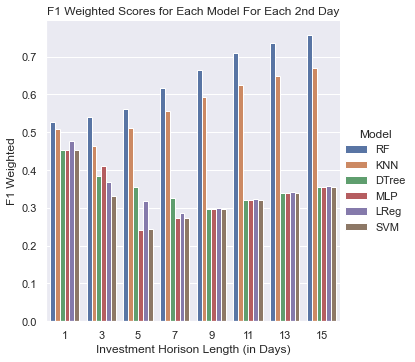

<Figure size 864x432 with 0 Axes>

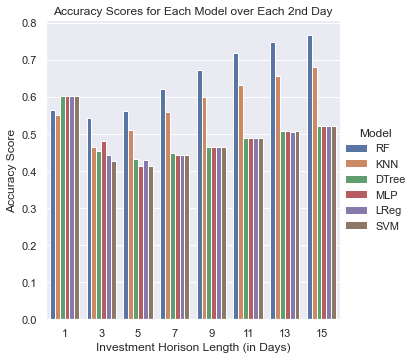

In [142]:
#Creating dtafarames suitable for visualising models' F1 and Accuracy Scores

#F1 DF
models_f1 = pd.DataFrame()
models_f1['day'] = reports['RF'].iloc[:,0]
for i in model_names:
    models_f1[i] = reports[i].iloc[:, 2]
models_f1 = models_f1.iloc[::2,:]
models_f1 = pd.melt(models_f1, id_vars="day", var_name="Model", value_name="F1 Weighted")

#F1 Vis
plt.figure(figsize=(12, 6))
vis4_sns = sns.factorplot(data=models_f1, x='day', y='F1 Weighted', 
hue='Model', kind='bar', legend=True)
vis4_sns.set(xlabel='Investment Horison Length (in Days)', ylabel='F1 Weighted')
vis4_sns.set(title='F1 Weighted Scores for Each Model For Each 2nd Day')
plt.show();

#Accuracy DF
models_acc = pd.DataFrame()
models_acc['day'] = reports['RF'].iloc[:,0]
for i in model_names:
    models_acc[i] = reports[i].iloc[:, 1]
models_acc = models_acc.iloc[::2,:]
models_acc = pd.melt(models_acc, id_vars="day", var_name="Model", value_name="Accuracy")

#Accuracy vis
plt.figure(figsize=(12, 6))
vis5_sns = sns.factorplot(data=models_acc, x='day', y='Accuracy', 
hue='Model', kind='bar', legend=True)
vis5_sns.set(xlabel='Investment Horison Length (in Days)', ylabel='Accuracy Score')
vis5_sns.set(title='Accuracy Scores for Each Model over Each 2nd Day')
plt.show();


Looking at the results, we can see that two models stand out form the rest: Random Forests and K-Neighbors, with F1 Weighted scores for the 15th day of 0.75 and 0.66, and accuracy of 0.77 and 0.68 respectively. This is a significant improvement from 0.33 if the classes were to be randomly guessed. We also see a clear trend: with the exception of day 1-3 period, the scores improve as the length of the investment horizon increases. One potential reason for this is that the value of our features must have a delayed, rather then an immediate effect on the stock prices.

These findings are very much consistent with the paper of Matloob and Khushi (2021), where 10th day's RF and KNN are also the best performing models. Albeit we must mention that our scores fall a few points short of the Matloob and Khushi models, which can be potentially explained by the fact that our data comprises only 10% of the data used in the original paper.

Due to the uncovered trends (and partly due to computational constraints) we decided to fine-tune the best two models only on the 15th day labels, since this is where we are most likely to get the best result.

Furthermore, we will also fine-tune one weak learner: an MLP Neural Network classifier. This is because one of the aims of this paper is to combine the models into a better solution, and as it is known weak learners sometime are able to boost ensemble performance, as their prediction errors are less correlated with those of strong learners.

Meanwhile, sell recall and buy precision of each model can be seen below:


<Figure size 864x432 with 0 Axes>

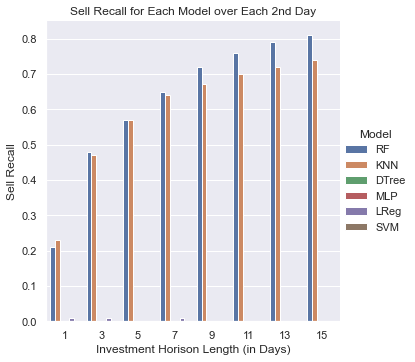

<Figure size 864x432 with 0 Axes>

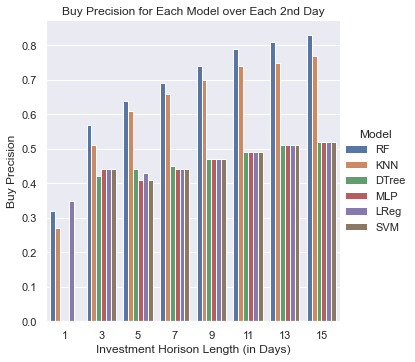

In [141]:
model_names = ['RF', 'KNN', 'DTree', 'MLP', 'LReg', 'SVM']

#Sell Recall DF
models_sell_rec = pd.DataFrame()
models_sell_rec['day'] = reports['RF'].iloc[:,0]
for i in model_names:
    models_sell_rec[i] = reports[i].iloc[:, 4]
models_sell_rec = models_sell_rec.iloc[::2,:]
models_sell_rec = pd.melt(models_sell_rec, id_vars="day", var_name="Model", value_name="Sell Recall")


#Sell Recall vis
plt.figure(figsize=(12, 6))
vis6_sns = sns.factorplot(data=models_sell_rec, x='day', y='Sell Recall', 
hue='Model', kind='bar', legend=True)
vis6_sns.set(xlabel='Investment Horison Length (in Days)', ylabel='Sell Recall')
vis6_sns.set(title='Sell Recall for Each Model over Each 2nd Day')
plt.show();

#Buy Precision DF
models_buy_pre = pd.DataFrame()
models_buy_pre['day'] = reports['RF'].iloc[:,0]
for i in model_names:
    models_buy_pre[i] = reports[i].iloc[:, 5]
models_buy_pre = models_buy_pre.iloc[::2,:]
models_buy_pre = pd.melt(models_buy_pre, id_vars="day", var_name="Model", value_name="Buy Precision")

#Buy Precision vis
plt.figure(figsize=(12, 6))
vis7_sns = sns.factorplot(data=models_buy_pre, x='day', y='Buy Precision', 
hue='Model', kind='bar', legend=True)
vis7_sns.set(xlabel='Investment Horison Length (in Days)', ylabel='Buy Precision')
vis7_sns.set(title='Buy Precision for Each Model over Each 2nd Day')
plt.show();


The patterns from the earlier visualisations can be observed here as well: scores increase with the length of the investment horizon and RF and KNN appear to be the best estimators. Furthermore, in case of Buy Precision, as in the case of Accuracy, LReg outperforms the two top models. Interestingly however, for Sell Recall only RF and KNN were able to produce sizeable scores.

## Fine-Tuning

To fine tune our models, we code a pipeline which uses random search over a pre-defined set of parameters and selects the best model through 10-fold cross validation (on train set) for each classifier passed into the pipeline. It then returns scores for each best model estimated on the test data.

In [45]:
#Pipeline with random search
def run_classifiers_gs(DF, model_list, model_names, grids):
    
    df = DF

    #Dropping N/As and selecting fatures/labels
    df.dropna(inplace=True)
    features = df.iloc[:,1:23]
    labels = df.iloc[:,23:]

    #Storage for test set scores, confusion matrices and best models
    results = pd.DataFrame(index=list(range(0, (len(models)))), columns=['Model Name', 'Accuracy', 'F1 Weighted',
    'Sell Recall', 'Buy Precison'])
    report_data = {}
    best_models = {}

    counter = 0


    for m in model_list:

        # specify the feature set, target set, the test size and random_state to select records randomly
        X_train, X_test, y_train, y_test = train_test_split(features, labels.iloc[:,14], test_size=0.3,random_state=42) 

        # Scaling values in the feature set
        scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)
        X_train = scaling.transform(X_train)
        X_test = scaling.transform(X_test)

        #Use the grid corresponfing to the classifier
        random_gridcv = grids[counter]

        clf = RandomizedSearchCV(m(), random_gridcv, cv = 10, scoring= 'f1_weighted')
        clf = clf.fit(X_train, y_train)

        #Output best accuracy and parameters found with the gridseacrh
        print(f'Best training f1 weighted score is {np.abs(clf.best_score_)}')
        print(f'Best set of parameters is  {clf.best_params_}')

        #Fitting and storing the best models
        params = clf.best_params_
        best = m().set_params(**params)
        best = best.fit(X_train, y_train)
        best_models[model_names[counter]] = best

        #Predicting y using the best model and X_test
        y_pred = best.predict(X_test)

        #Calculating and storing test scores
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1_w = metrics.f1_score(y_test, y_pred, average='weighted')


        # f1_scores =[] 
        # f1_scores.insert(2, metrics.f1_score(y_test, y_pred, average='weighted'))
        report = classification_report(y_test, y_pred)
        # unravel report for the given day       
        lines = report.split('\n')
        for line in lines[2:-5]:

            row_data = line.split('     ')

            # update recall for sell
            if(float(row_data[1])==0.0):
                results.loc[counter, 'Sell Recall']= float(row_data[3])
            # update precison for buy
            if(float(row_data[1])==2.0):
                results.loc[counter, 'Buy Precison']= float(row_data[2])


        results.loc[counter, 'Model Name'] = model_names[counter]
        results.loc[counter, 'Accuracy'] = accuracy
        results.loc[counter, 'F1 Weighted'] = f1_w
        
        #Calculating and storing confusion matrices
        report = classification_report(y_test, y_pred)
        report_data[model_names[counter]] = report

        print("\n Completed fitting", model_names[counter], '\n')

        counter += 1
    
    return results, report_data, best_models

In [67]:
#Defining the classifiers
RF = RandomForestClassifier
KNN = KNeighborsClassifier
MLP = MLPClassifier

models = [RF, KNN, MLP]
model_names = ['RF', 'KNN', 'MLP']

#Defining the parameters to search over
grids = [{
 'random_state': [42],
 'n_jobs':[-1],
 'n_estimators': [5,10,20,40,50],
 'criterion' : ['gini','entropy'],
 'class_weight' : [None, 'balanced']
 },
 {
 'n_neighbors': [2,3,4,5],
 'weights':['distance', 'uniform'],
 'n_jobs':[-1]
 },
 {
 'random_state': [42],
 'solver' : ['lbfgs', 'sgd'], 
 'alpha' : [0.5, 1, 1.5, 2, 2.5, 3], 
 'hidden_layer_sizes' : [x for x in itertools.product((2,3,4,5),repeat=2)],
 'activation' : ['tanh', 'relu']
 }]

#Running the random search
test_scores, confusion_mx, best_est_models = run_classifiers_gs(df_new, models, model_names, grids)

Best training f1 weighted score is 0.7744372499574687
Best set of parameters is  {'random_state': 42, 'n_jobs': -1, 'n_estimators': 50, 'criterion': 'gini', 'class_weight': None}

 Completed fitting RF 

Best training f1 weighted score is 0.7006844306109542
Best set of parameters is  {'weights': 'distance', 'n_neighbors': 2, 'n_jobs': -1}

 Completed fitting KNN 

Best training f1 weighted score is 0.35511188529020565
Best set of parameters is  {'solver': 'lbfgs', 'random_state': 42, 'hidden_layer_sizes': (4, 5), 'alpha': 2.5, 'activation': 'relu'}

 Completed fitting MLP 



In [161]:
#The random search results
test_scores
best_est_models

,Model Name,Accuracy,F1 Weighted,Sell Recall,Buy Precison
0,RF,0.797944,0.785168,0.83,0.83
1,KNN,0.708726,0.70967,0.72,0.8
2,MLP,0.516862,0.352235,0.0,0.52


{'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42),
 'KNN': KNeighborsClassifier(n_jobs=-1, n_neighbors=2, weights='distance'),
 'MLP': MLPClassifier(alpha=2.5, hidden_layer_sizes=(4, 5), random_state=42,
               solver='lbfgs')}

Looking at the F1 Weighted score, it appears that as a result of fine-tuning our models scores increased incrementally: by 3% and 5% for RF and KNN, whilst MLP peroformance largely remained the same.

It is important to recognise, that some of the picked parameters values, lied on the end of the grids in the pipeline. This means that the grids should be extended. However, due to computational constraints we leave this to further research.

## Voting Classifier

In [156]:
#Splitting the data into train and split and running the classifier with
#the fine-tuned models
df = df_new

#Dropping N/As and selecting fatures/labels
df.dropna(inplace=True)
features = df.iloc[:,1:23]
labels = df.iloc[:,23:]

X_train, X_test, y_train, y_test = train_test_split(features, labels.iloc[:,14], test_size=0.3,random_state=42)
scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)


vote = VotingClassifier(estimators=[
    ('RF', best_est_models['RF']),
    ('KNN', best_est_models['KNN']),
    ('MLP', best_est_models['MLP'])],
    voting = 'hard')

vote = vote.fit(X_train, y_train)

y_pred = vote.predict(X_test)
f1_weighted =  metrics.f1_score(y_test, y_pred, average='weighted')
print('Voting classifier F1 Weighted score is:', f1_weighted)


Voting classifier F1 Weighted score is: 0.7496859444371246


It appears that voting does not immediately lead to a better-performing model, as the resulting classifier has a F1 score less than a usual RF model (0.75 < 0.79).  Following this result, we tried to change model weights in different manners, but this did not result in a better performance. It is likely that prediction errors of the 3 models are not sufficiently different to produce a better result when combined with each other.

## Conclusion

Hence our best model remains a Random Forest with 50 estimators. We recognise that n=50 was on the upper bound of the grid when fine-tuning the models, hence in further research the bound should be extended, which might allow to produce a better model. Furthermore, further research should focus on extending the length of the investment horizon to find the value where model performance peaks.

In conclusion, this paper has produced a model capable of recommending the best strategy for an investor in S&P55 index seeking to collect his returns in 15 days time with 80% accuracy – almost 2.5 times increase from 33% of base (random) model. This model is suitable for use to any business interested in yielding returns on the stock market.